In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive/MyDrive/Home-Credit-Default-Risk/

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import operator
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import train_test_split

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDClassifier, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBClassifier
import lightgbm as lgbm

pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

# Feature selection of "application"

In [ ]:
# read in "application" dataset
df_train = pd.read_csv('./Data/application_train.csv')
df_test = pd.read_csv('./Data/application_test.csv')

In [ ]:
### Removing outliers

### DAYS features
df_train['DAYS_EMPLOYED'][df_train['DAYS_EMPLOYED'] == 365243] = np.nan
df_test['DAYS_EMPLOYED'][df_test['DAYS_EMPLOYED'] == 365243] = np.nan

df_train = df_train[df_train['CODE_GENDER'] != 'XNA'] # Remove rows with 'XNA' as 'CODE_GENDER'

In [ ]:
print("Shape of training data is: {}; \nShape of test data is: {}".format(df_train.shape, df_test.shape))

Shape of training data is: (307507, 122); 
Shape of test data is: (48744, 121)


In [ ]:
df_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
## we noticed that the positive / negative samples are imbalance
label_count = df_train['TARGET'].value_counts()
print(label_count)

0    282682
1     24825
Name: TARGET, dtype: int64


In [ ]:
train_X = df_train.loc[:,df_test.columns]
train_y = df_train['TARGET']
test_X = df_test
print("If the order of attributes for training data and test data are the same: {}".format(list(train_X.columns)==list(train_X.columns)))

If the order of attributes for training data and test data are the same: True


In [ ]:
print('Number of numerical attributes: {}'.format(sum(train_X.dtypes != 'object')))
print('Number of categorical attributes: {}'.format(sum(train_X.dtypes == 'object')))
numericFeat = train_X.columns[train_X.dtypes != 'object']
categoricFeat = train_X.columns[train_X.dtypes == 'object']
print("All the categorical attributes are: ", categoricFeat)

Number of numerical attributes: 105
Number of categorical attributes: 16
All the categorical attributes are:  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')


In [ ]:
train_X_numeric, test_X_numeric = train_X[numericFeat], test_X[numericFeat]
train_X_categoric, test_X_categoric = train_X[categoricFeat], test_X[categoricFeat]
print(train_X_numeric.shape, test_X_numeric.shape)

(307507, 105) (48744, 105)


# Feature extraction from "credit_card_balance"

In [ ]:
df_credit = pd.read_csv('./Data/credit_card_balance.csv')

In [ ]:
print("Original dimension of credit_card_balance dataset is: ",df_credit.shape)
df_credit.head(3)

Original dimension of credit_card_balance dataset is:  (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0


In [ ]:
df_credit = df_credit[df_credit.columns[df_credit.dtypes != 'object']]
del df_credit['SK_ID_PREV']
print("Dimension of credit_card_balance dataset after numerical variable selection is: ",df_credit.shape)

Dimension of credit_card_balance dataset after numerical variable selection is:  (3840312, 21)


In [ ]:
credit_agg = df_credit.groupby(by = ['SK_ID_CURR']).agg(['min', 'max', 'mean', 'std']).reset_index()
print("The shape of aggregated credit document is: ",credit_agg.shape)
credit_agg.head(5)

The shape of aggregated credit document is:  (103558, 81)


SK_ID_CURR MONTHS_BALANCE                      AMT_BALANCE             \
                        min max  mean        std         min        max   
0     100006             -6  -1  -3.5   1.870829         0.0       0.00   
1     100011            -75  -2 -38.5  21.505813         0.0  189000.00   
2     100013            -96  -1 -48.5  27.856777         0.0  161420.22   
3     100021            -18  -2 -10.0   5.049752         0.0       0.00   
4     100023            -11  -4  -7.5   2.449490         0.0       0.00   

                              AMT_CREDIT_LIMIT_ACTUAL                         \
           mean           std                     min     max           mean   
0      0.000000      0.000000                  270000  270000  270000.000000   
1  54482.111149  68127.238270                   90000  180000  164189.189189   
2  18159.919219  43237.406997                   45000  157500  131718.750000   
3      0.000000      0.000000                  675000  675000  675000.000000   
4      0.000000      0.000000                   45000  225000  135000.000000   

                AMT_DRAWINGS_ATM_CURRENT                                       \
            std                      min       max         mean           std   
0      0.000000                      NaN       NaN          NaN           NaN   
1  34482.743620                      0.0  180000.0  2432.432432  20924.574974   
2  47531.585759                      0.0  157500.0  6350.000000  28722.270457   
3      0.000000                      NaN       NaN          NaN           NaN   
4  96214.047088                      NaN       NaN          NaN           NaN   

  AMT_DRAWINGS_CURRENT                                       \
                   min       max         mean           std   
0                  0.0       0.0     0.000000      0.000000   
1                  0.0  180000.0  2432.432432  20924.574974   
2                  0.0  157500.0  5953.125000  27843.366225   
3                  0.0       0.0     0.000000      0.000000   
4                  0.0       0.0     0.000000      0.000000   

  AMT_DRAWINGS_OTHER_CURRENT                AMT_DRAWINGS_POS_CURRENT       \
                         min  max mean  std                      min  max   
0                        NaN  NaN  NaN  NaN                      NaN  NaN   
1                        0.0  0.0  0.0  0.0                      0.0  0.0   
2                        0.0  0.0  0.0  0.0                      0.0  0.0   
3                        NaN  NaN  NaN  NaN                      NaN  NaN   
4                        NaN  NaN  NaN  NaN                      NaN  NaN   

            AMT_INST_MIN_REGULARITY                                    \
  mean  std                     min     max         mean          std   
0  NaN  NaN                     0.0     0.0     0.000000     0.000000   
1  0.0  0.0                     0.0  9000.0  3956.221849  4487.750710   
2  0.0  0.0                     0.0  7875.0  1454.539551  3028.409304   
3  NaN  NaN                     0.0     0.0     0.000000     0.000000   
4  NaN  NaN                     0.0     0.0     0.000000     0.000000   

  AMT_PAYMENT_CURRENT                                       \
                  min       max         mean           std   
0                 NaN       NaN          NaN           NaN   
1                 0.0   55485.0  4843.064189   7279.601955   
2                 0.0  153675.0  7168.346250  21626.144325   
3                 NaN       NaN          NaN           NaN   
4                 NaN       NaN          NaN           NaN   

  AMT_PAYMENT_TOTAL_CURRENT                                       \
                        min       max         mean           std   
0                       0.0       0.0     0.000000      0.000000   
1                       0.0   55485.0  4520.067568   7473.872687   
2                       0.0  153675.0  6817.172344  21730.655260   
3                       0.0       0.0     0.000000      0.000000   
4         

In [ ]:
train_X_merge = pd.merge(train_X_numeric, credit_agg, how = 'left', on = 'SK_ID_CURR')
test_X_merge = pd.merge(test_X_numeric, credit_agg, how = 'left', on = 'SK_ID_CURR')
print(train_X_merge.shape, test_X_merge.shape)

(307507, 185) (48744, 185)


In [ ]:
train_X_merge.head(3)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,"(MONTHS_BALANCE, min)","(MONTHS_BALANCE, max)","(MONTHS_BALANCE, mean)","(MONTHS_BALANCE, std)","(AMT_BALANCE, min)","(AMT_BALANCE, max)","(AMT_BALANCE, mean)","(AMT_BALANCE, std)","(AMT_CREDIT_LIMIT_ACTUAL, min)","(AMT_CREDIT_LIMIT_ACTUAL, max)","(AMT_CREDIT_LIMIT_ACTUAL, mean)","(AMT_CREDIT_LIMIT_ACTUAL, std)","(AMT_DRAWINGS_ATM_CURRENT, min)","(AMT_DRAWINGS_ATM_CURRENT, max)","(AMT_DRAWINGS_ATM_CURRENT, mean)","(AMT_DRAWINGS_ATM_CURRENT, std)","(AMT_DRAWINGS_CURRENT, min)","(AMT_DRAWINGS_CURRENT, max)","(AMT_DRAWINGS_CURRENT, mean)","(AMT_DRAWINGS_CURRENT, std)","(AMT_DRAWINGS_OTHER_CURRENT, min)","(AMT_DRAWINGS_OTHER_CURRENT, max)","(AMT_DRAWINGS_OTHER_CURRENT, mean)","(AMT_DRAWINGS_OTHER_CURRENT, std)","(AMT_DRAWINGS_POS_CURRENT, min)","(AMT_DRAWINGS_POS_CURRENT, max)","(AMT_DRAWINGS_POS_CURRENT, mean)","(AMT_DRAWINGS_POS_CURRENT, std)","(AMT_INST_MIN_REGULARITY, min)","(AMT_INST_MIN_REGULARITY, max)","(AMT_INST_MIN_REGULARITY, mean)","(AMT_INST_MIN_REGULARITY, std)","(AMT_PAYMENT_CURRENT, min)","(AMT_PAYMENT_CURRENT, max)","(AMT_PAYMENT_CURRENT, mean)","(AMT_PAYMENT_CURRENT, std)","(AMT_PAYMENT_TOTAL_CURRENT, min)","(AMT_PAYMENT_TOTAL_CURRENT, max)","(AMT_PAYMENT_TOTAL_CURRENT, mean)","(AMT_PAYMENT_TOTAL_CURRENT, std)","(AMT_RECEIVABLE_PRINCIPAL, min)","(AMT_RECEIVABLE_PRINCIPAL, max)","(AMT_RECEIVABLE_PRINCIPAL, mean)","(AMT_RECEIVABLE_PRINCIPAL, std)","(AMT_RECIVABLE, min)","(AMT_RECIVABLE, max)","(AMT_RECIVABLE, mean)","(AMT_RECIVABLE, std)","(AMT_TOTAL_RECEIVABLE, min)","(AMT_TOTAL_RECEIVABLE, max)","(AMT_TOTAL_RECEIVABLE, mean)","(AMT_TOTAL_RECEIVABLE, std)","(CNT_DRAWINGS_ATM_CURRENT, min)","(CNT_DRAWINGS_ATM_CURRENT, max)","(CNT_DRAWINGS_ATM_CURRENT, mean)","(CNT_DRAWINGS_ATM_CURRENT, std)","(CNT_DRAWINGS_CURRENT, min)","(CNT_DRAWINGS_CURRENT, max)","(CNT_DRAWINGS_CURRENT, mean)","(CNT_DRAWINGS_CURRENT, std)","(CNT_DRAWINGS_OTHER_CURRENT, min)","(CNT_DRAWINGS_OTHER_CURRENT, max)","(CNT_DRAWINGS_OTHER_CURRENT, mean)","(CNT_DRAWINGS_OTHER_CURRENT, std)","(CNT_DRAWINGS_POS_CURRENT, min)","(CNT_DRAWINGS_POS_CURRENT, max)","(CNT_DRAWINGS_POS_CU


# Feature extraction from "POS_CASH_balance"

In [ ]:
df_POS = pd.read_csv('./Data/POS_CASH_balance.csv')

In [ ]:
print("Original dimension of credit_card_balance dataset is: ",df_POS.shape)
df_POS.head(3)

Original dimension of credit_card_balance dataset is:  (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0


In [ ]:
df_POS = df_POS[df_POS.columns[df_POS.dtypes != 'object']]
del df_POS['SK_ID_PREV']
print("Dimension of POS_CASH_balance dataset after numerical variable selection is: ",df_POS.shape)

Dimension of POS_CASH_balance dataset after numerical variable selection is:  (10001358, 6)


In [ ]:
POS_agg = df_POS.groupby(by = ['SK_ID_CURR']).agg(['min', 'max', 'mean', 'std']).reset_index()
print(POS_agg.shape)

(337252, 21)


In [ ]:
train_X_merge = pd.merge(train_X_merge, POS_agg, how = 'left', on = 'SK_ID_CURR')
test_X_merge = pd.merge(test_X_merge, POS_agg, how = 'left', on = 'SK_ID_CURR')
print(train_X_merge.shape, test_X_merge.shape)

(307507, 205) (48744, 205)



# Feature extraction from "previous_application.csv"

In [ ]:
df_PRE = pd.read_csv('./Data/previous_application.csv')

In [ ]:
del df_PRE['SK_ID_PREV']

df_PRE['NAME_CONTRACT_STATUS'] = df_PRE['NAME_CONTRACT_STATUS'].replace('Approved', 1)
df_PRE['NAME_CONTRACT_STATUS'][df_PRE['NAME_CONTRACT_STATUS']!=1] = 0

df_PRE.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,1,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,1,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,1,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,1,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,0,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,Y,1,NaN,NaN,NaN,Everyday expenses,1,-684,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
6,175704,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,0,-14,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
7,296299,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,0,-21,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
8,342292,Cash loans,NaN,0.0,0.0,NaN,NaN,MONDAY,15,Y,1,NaN,NaN,NaN,XNA,0,-386,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
9,334349,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,15,Y,1,NaN,NaN,NaN,XNA,0,-57,XNA,XAP,NaN,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_PRE = df_PRE[df_PRE.columns[df_PRE.dtypes != 'object']]
print("Dimension of previous_application dataset after numerical variable selection is: ",df_PRE.shape)

Dimension of previous_application dataset after numerical variable selection is:  (1670214, 20)


In [ ]:
PRE_agg = df_PRE.groupby(by = ['SK_ID_CURR']).agg(['min', 'max', 'mean', 'std']).reset_index()
print(PRE_agg.shape)

(338857, 77)


In [ ]:
train_X_merge = pd.merge(train_X_merge, PRE_agg, how = 'left', on = 'SK_ID_CURR')
test_X_merge = pd.merge(test_X_merge, PRE_agg, how = 'left', on = 'SK_ID_CURR')
print(train_X_merge.shape, test_X_merge.shape)

(307507, 281) (48744, 281)


# Numerical Feature Engineering

In [ ]:
'''
  Construct some simple percentages features
'''
def add_features(df):

    df['DAYS_EMPLOYED_BIRTH_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['ANNUITY_CREDIT_PERC'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['AMT_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['AMT_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['AMT_INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df["AMT_CREDIT_GOODS_PERC"] = df["AMT_CREDIT"] / df["AMT_GOODS_PRICE"]
    df["AMT_CREDIT_GOODS_DIFF"] = df["AMT_CREDIT"] - df["AMT_GOODS_PRICE"]

    return df

In [ ]:
train_X_merge = add_features(train_X_merge)
test_X_merge = add_features(test_X_merge)

# Categorical Feature Engineering

In [ ]:
train_X_categoric.head(3)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN


In [ ]:
Total_train = pd.concat([train_X_categoric, test_X_categoric], axis=0).reset_index(drop=True)

In [ ]:
# Fill missing value with 'Unknow' (if use lightgmb, you can skip it)
for column in list(Total_train.columns[Total_train.isnull().sum() > 0]):
    fill_val = 'Unknown'
    Total_train[column].fillna(fill_val, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
le = LabelEncoder()
column_list = []

In [ ]:
# Encoding binary categories
for column in Total_train.columns:
  temp = dict(Total_train[column].value_counts())
  if len(temp.keys()) == 2:
      encode = le.fit_transform(Total_train[column])
      Total_train[column] = encode
  else:
      column_list.append(column)

In [ ]:
# Encoding hierachical categories
level = {'Lower secondary':0, 'Secondary / secondary special':1, 'Incomplete higher':2, 'Higher education':3, 'Academic degree':4}
Total_train['NAME_EDUCATION_TYPE'] = Total_train['NAME_EDUCATION_TYPE'].map(lambda x: level[x])

In [ ]:
# Encoding the remaining categories
Total_train = pd.get_dummies(Total_train, columns=[name for name in column_list if name != 'NAME_EDUCATION_TYPE'], dummy_na=True)

In [ ]:
Total_train.head(5)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_Unknown,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unknown,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan,FONDKAPREMONT_MODE_Unknown,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,FONDKAPREMONT_MODE_nan,HOUSETYPE_MODE_Unknown,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced

In [ ]:
Total_train.shape

(356251, 148)

In [ ]:
# Fill missing value with mean value (if use lightgmb, you can skip it)
for column in list(train_X_merge.columns[train_X_merge.isnull().sum() > 0]):
    mean_val = train_X_merge[column].mean()
    train_X_merge[column].fillna(mean_val, inplace=True)

for column in list(test_X_merge.columns[test_X_merge.isnull().sum() > 0]):
    mean_val = test_X_merge[column].mean()
    test_X_merge[column].fillna(mean_val, inplace=True)

In [ ]:
temp1 = Total_train.iloc[:train_X_merge.shape[0],:]
temp2 = Total_train.iloc[train_X_merge.shape[0]:,:].reset_index(drop=True)

In [ ]:
new_train_X = pd.concat([train_X_merge, temp1], axis=1)
new_test_X = pd.concat([test_X_merge, temp2], axis=1)

In [ ]:
print(new_train_X.shape)
print(new_test_X.shape)

(307507, 436)
(307507, 436)


In [ ]:
new_train_X.head(3)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,"('MONTHS_BALANCE', 'min')_x","('MONTHS_BALANCE', 'max')_x","('MONTHS_BALANCE', 'mean')_x","('MONTHS_BALANCE', 'std')_x","(AMT_BALANCE, min)","(AMT_BALANCE, max)","(AMT_BALANCE, mean)","(AMT_BALANCE, std)","(AMT_CREDIT_LIMIT_ACTUAL, min)","(AMT_CREDIT_LIMIT_ACTUAL, max)","(AMT_CREDIT_LIMIT_ACTUAL, mean)","(AMT_CREDIT_LIMIT_ACTUAL, std)","(AMT_DRAWINGS_ATM_CURRENT, min)","(AMT_DRAWINGS_ATM_CURRENT, max)","(AMT_DRAWINGS_ATM_CURRENT, mean)","(AMT_DRAWINGS_ATM_CURRENT, std)","(AMT_DRAWINGS_CURRENT, min)","(AMT_DRAWINGS_CURRENT, max)","(AMT_DRAWINGS_CURRENT, mean)","(AMT_DRAWINGS_CURRENT, std)","(AMT_DRAWINGS_OTHER_CURRENT, min)","(AMT_DRAWINGS_OTHER_CURRENT, max)","(AMT_DRAWINGS_OTHER_CURRENT, mean)","(AMT_DRAWINGS_OTHER_CURRENT, std)","(AMT_DRAWINGS_POS_CURRENT, min)","(AMT_DRAWINGS_POS_CURRENT, max)","(AMT_DRAWINGS_POS_CURRENT, mean)","(AMT_DRAWINGS_POS_CURRENT, std)","(AMT_INST_MIN_REGULARITY, min)","(AMT_INST_MIN_REGULARITY, max)","(AMT_INST_MIN_REGULARITY, mean)","(AMT_INST_MIN_REGULARITY, std)","(AMT_PAYMENT_CURRENT, min)","(AMT_PAYMENT_CURRENT, max)","(AMT_PAYMENT_CURRENT, mean)","(AMT_PAYMENT_CURRENT, std)","(AMT_PAYMENT_TOTAL_CURRENT, min)","(AMT_PAYMENT_TOTAL_CURRENT, max)","(AMT_PAYMENT_TOTAL_CURRENT, mean)","(AMT_PAYMENT_TOTAL_CURRENT, std)","(AMT_RECEIVABLE_PRINCIPAL, min)","(AMT_RECEIVABLE_PRINCIPAL, max)","(AMT_RECEIVABLE_PRINCIPAL, mean)","(AMT_RECEIVABLE_PRINCIPAL, std)","(AMT_RECIVABLE, min)","(AMT_RECIVABLE, max)","(AMT_RECIVABLE, mean)","(AMT_RECIVABLE, std)","(AMT_TOTAL_RECEIVABLE, min)","(AMT_TOTAL_RECEIVABLE, max)","(AMT_TOTAL_RECEIVABLE, mean)","(AMT_TOTAL_RECEIVABLE, std)","(CNT_DRAWINGS_ATM_CURRENT, min)","(CNT_DRAWINGS_ATM_CURRENT, max)","(CNT_DRAWINGS_ATM_CURRENT, mean)","(CNT_DRAWINGS_ATM_CURRENT, std)","(CNT_DRAWINGS_CURRENT, min)","(CNT_DRAWINGS_CURRENT, max)","(CNT_DRAWINGS_CURRENT, mean)","(CNT_DRAWINGS_CURRENT, std)","(CNT_DRAWINGS_OTHER_CURRENT, min)","(CNT_DRAWINGS_OTHER_CURRENT, max)","(CNT_DRAWINGS_OTHER_CURRENT, mean)","(CNT_DRAWINGS_OTHER_CURRENT, std)","(CNT_DRAWINGS_POS_CURRENT, min)","(CNT_DRAWINGS_POS_CURRENT, max

In [ ]:
del new_train_X['SK_ID_CURR']
del new_test_X['SK_ID_CURR']

# Feature Selection

In [ ]:
new_train_X.head(3)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,"('MONTHS_BALANCE', 'min')_x","('MONTHS_BALANCE', 'max')_x","('MONTHS_BALANCE', 'mean')_x","('MONTHS_BALANCE', 'std')_x","(AMT_BALANCE, min)","(AMT_BALANCE, max)","(AMT_BALANCE, mean)","(AMT_BALANCE, std)","(AMT_CREDIT_LIMIT_ACTUAL, min)","(AMT_CREDIT_LIMIT_ACTUAL, max)","(AMT_CREDIT_LIMIT_ACTUAL, mean)","(AMT_CREDIT_LIMIT_ACTUAL, std)","(AMT_DRAWINGS_ATM_CURRENT, min)","(AMT_DRAWINGS_ATM_CURRENT, max)","(AMT_DRAWINGS_ATM_CURRENT, mean)","(AMT_DRAWINGS_ATM_CURRENT, std)","(AMT_DRAWINGS_CURRENT, min)","(AMT_DRAWINGS_CURRENT, max)","(AMT_DRAWINGS_CURRENT, mean)","(AMT_DRAWINGS_CURRENT, std)","(AMT_DRAWINGS_OTHER_CURRENT, min)","(AMT_DRAWINGS_OTHER_CURRENT, max)","(AMT_DRAWINGS_OTHER_CURRENT, mean)","(AMT_DRAWINGS_OTHER_CURRENT, std)","(AMT_DRAWINGS_POS_CURRENT, min)","(AMT_DRAWINGS_POS_CURRENT, max)","(AMT_DRAWINGS_POS_CURRENT, mean)","(AMT_DRAWINGS_POS_CURRENT, std)","(AMT_INST_MIN_REGULARITY, min)","(AMT_INST_MIN_REGULARITY, max)","(AMT_INST_MIN_REGULARITY, mean)","(AMT_INST_MIN_REGULARITY, std)","(AMT_PAYMENT_CURRENT, min)","(AMT_PAYMENT_CURRENT, max)","(AMT_PAYMENT_CURRENT, mean)","(AMT_PAYMENT_CURRENT, std)","(AMT_PAYMENT_TOTAL_CURRENT, min)","(AMT_PAYMENT_TOTAL_CURRENT, max)","(AMT_PAYMENT_TOTAL_CURRENT, mean)","(AMT_PAYMENT_TOTAL_CURRENT, std)","(AMT_RECEIVABLE_PRINCIPAL, min)","(AMT_RECEIVABLE_PRINCIPAL, max)","(AMT_RECEIVABLE_PRINCIPAL, mean)","(AMT_RECEIVABLE_PRINCIPAL, std)","(AMT_RECIVABLE, min)","(AMT_RECIVABLE, max)","(AMT_RECIVABLE, mean)","(AMT_RECIVABLE, std)","(AMT_TOTAL_RECEIVABLE, min)","(AMT_TOTAL_RECEIVABLE, max)","(AMT_TOTAL_RECEIVABLE, mean)","(AMT_TOTAL_RECEIVABLE, std)","(CNT_DRAWINGS_ATM_CURRENT, min)","(CNT_DRAWINGS_ATM_CURRENT, max)","(CNT_DRAWINGS_ATM_CURRENT, mean)","(CNT_DRAWINGS_ATM_CURRENT, std)","(CNT_DRAWINGS_CURRENT, min)","(CNT_DRAWINGS_CURRENT, max)","(CNT_DRAWINGS_CURRENT, mean)","(CNT_DRAWINGS_CURRENT, std)","(CNT_DRAWINGS_OTHER_CURRENT, min)","(CNT_DRAWINGS_OTHER_CURRENT, max)","(CNT_DRAWINGS_OTHER_CURRENT, mean)","(CNT_DRAWINGS_OTHER_CURRENT, std)","(CNT_DRAWINGS_POS_CURRENT, min)","(CNT_DRAWINGS_POS_CURRENT, max)","(CNT_DR

In [ ]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr

#new_train_X = SelectKBest(lambda X, Y: np.array(list(map(lambda x: pearsonr(x, Y)[0], X.T))).T, k=100).fit_transform(new_train_X, train_y)
#new_train_X = SelectKBest(lambda X, Y: np.array(list(map(lambda x: pearsonr(x, Y)[0], X.T))).T, k=200).fit_transform(new_train_X, train_y)
#new_train_X = SelectKBest(lambda X, Y: np.array(list(map(lambda x: pearsonr(x, Y)[0], X.T))).T, k=300).fit_transform(new_train_X, train_y)
new_train_X = SelectKBest(lambda X, Y: np.array(list(map(lambda x: pearsonr(x, Y)[0], X.T))).T, k=400).fit_transform(new_train_X, train_y)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
#pca = PCA(n_components=100)
#pca = PCA(n_components=200)
#pca = PCA(n_components=300)
pca = PCA(n_components=400)
new_train_X = pca.fit_transform(scale(new_train_X))

In [ ]:
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 50)
valid_scores = []
train_scores = []
round=0

for train_indices, valid_indices in k_fold.split(new_train_X):

    # Training and Validation data for the fold
    train_features, train_labels = new_train_X[train_indices], np.array(train_y)[train_indices]
    valid_features, valid_labels = new_train_X[valid_indices], np.array(train_y)[valid_indices]

    # Create the model
    model = lgbm.LGBMClassifier(n_estimators=800, objective = 'binary', class_weight = 'balanced', learning_rate = 0.05, 
                               reg_alpha = 0.1, reg_lambda = 0.1, subsample = 0.8, n_jobs = -1, random_state = 50)

    # Train the model
    model.fit(train_features, train_labels, eval_metric = 'auc',
              eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
              eval_names = ['valid', 'train'], 
              early_stopping_rounds = 200, verbose = 200)

    print("{}_round".format(round))
    round+=1

Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.827505	train's binary_logloss: 0.535374	valid's auc: 0.743359	valid's binary_logloss: 0.558259
[400]	train's auc: 0.877414	train's binary_logloss: 0.479993	valid's auc: 0.749407	valid's binary_logloss: 0.521065
[600]	train's auc: 0.910896	train's binary_logloss: 0.439094	valid's auc: 0.749298	valid's binary_logloss: 0.494209
Early stopping, best iteration is:
[451]	train's auc: 0.887307	train's binary_logloss: 0.468685	valid's auc: 0.749877	valid's binary_logloss: 0.513646
0_round
Training until validation scores don't improve for 200 rounds.
[200]	train's auc: 0.825941	train's binary_logloss: 0.537321	valid's auc: 0.754022	valid's binary_logloss: 0.557577
[400]	train's auc: 0.875563	train's binary_logloss: 0.482899	valid's auc: 0.758492	valid's binary_logloss: 0.520281
Early stopping, best iteration is:
[399]	train's auc: 0.87534	train's binary_logloss: 0.483129	valid's auc: 0.758495	valid's binary_log


# Model Part

#### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

x_train, x_val, y_train, y_val = train_test_split(new_train_X, train_y, test_size = 0.2, random_state = 2022)

clf = LogisticRegression(
            random_state = 0,
            C = 1.0,
            max_iter = 100,
            )

C = [0.1, 1, 10]
max_iter = [10, 100, 1000]
param_grid = dict(C=C, max_iter=max_iter)
kflod = KFold(n_splits=5, shuffle=True,random_state=0)

grid_search = GridSearchCV(clf,param_grid,scoring='neg_log_loss',n_jobs=-1,cv=kflod)
grid_result = grid_search.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))

means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f with: %r" % (mean, param))

In [ ]:
clf = LogisticRegression(
            random_state = 0,
            C = grid_search.best_params_["C"],
            max_iter = grid_search.best_params_["max_iter"],
            )
clf.fit(x_train, y_train)

In [ ]:
pred = clf.predict(x_val)

In [ ]:
from sklearn.metrics import roc_auc_score

# score of the model
auc_result = roc_auc_score(y_val, pred)
print("The Area Under the ROC Curve is", auc_result)

#### SVM

In [ ]:
from sklearn.svm import SVC

x_train, x_val, y_train, y_val = train_test_split(new_train_X, train_y, test_size = 0.2, random_state = 2022)

clf = SVC(
        random_state = 0,
        C = 1.0,
        kernel = 'rbf',
        max_iter = 100,
        )

C = [0.1, 1, 10]
kernel = ['linear', 'poly', 'rbf']
param_grid = dict(C=C, kernel=kernel)
kflod = KFold(n_splits=5, shuffle=True,random_state=0)

grid_search = GridSearchCV(clf,param_grid,scoring='neg_log_loss',n_jobs=-1,cv=kflod)
grid_result = grid_search.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))

means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f with: %r" % (mean, param))

In [ ]:
clf = SVC(
        random_state = 0,
        C = grid_search.best_params_["C"],
        kernel = grid_search.best_params_["kernel"],
        max_iter = 100,
        )
clf.fit(x_train, y_train)

In [ ]:
pred = clf.predict(x_val)

In [ ]:
from sklearn.metrics import roc_auc_score

# score of the model
auc_result = roc_auc_score(y_val, pred)
print("The Area Under the ROC Curve is", auc_result)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm
import gc

# Record data
features = new_train_X
labels = train_y
test_features = new_test_X

# Empty array for feature importances
feature_names = list(features.columns)
feature_importance_values = np.zeros(features.shape[1])

# Empty array for test predictions
test_predictions = np.zeros(test_features.shape[0])

# Empty array for out of fold validation predictions
out_of_fold = np.zeros(features.shape[0])

# Lists for recording validation and training scores
valid_scores = []
train_scores = []

# Create the kfold object
n_folds=5
k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

# Iterate through each fold
for train_indices, valid_indices in k_fold.split(features):

    # Training data for the fold
    train_features, train_labels = features.to_numpy()[train_indices], np.array(labels)[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = features.to_numpy()[valid_indices], np.array(labels)[valid_indices]

    # Create the model
    model = lgbm.LGBMClassifier(n_estimators=1000, 
                                objective = 'binary', 
                                class_weight = 'balanced', 
                                learning_rate = 0.05, 
                                reg_alpha = 0.1, 
                                reg_lambda = 0.1, 
                                subsample = 0.8, 
                                n_jobs = -1, 
                                random_state = 50,
                               )

    # Train the model
    model.fit(train_features, train_labels, 
              eval_metric = 'auc',
              eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
              eval_names = ['valid', 'train'],
              early_stopping_rounds = 100, 
              verbose = 200
             )

    # Record the best iteration
    best_iteration = model.best_iteration_

    # Record the feature importances
    feature_importance_values += model.feature_importances_ / k_fold.n_splits

    # Make predictions
    test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

    # Record the out of fold predictions
    out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

    # Record the best score
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']

    valid_scores.append(valid_score)
    train_scores.append(train_score)

    # Clean up memory
    gc.enable()
    del model, train_features, valid_features
    gc.collect()

df_submission = pd.read_csv('./Data/sample_submission.csv')
test_ids = df_submission['TARGET']

# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

# Make the feature importance dataframe
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

# Overall validation score
valid_auc = roc_auc_score(labels, out_of_fold)

# Add the overall scores to the metrics
valid_scores.append(valid_auc)
train_scores.append(np.mean(train_scores))

# Needed for creating dataframe of validation scores
fold_names = list(range(n_folds))
fold_names.append('overall')

# Dataframe of validation scores
metrics = pd.DataFrame({'fold': fold_names,
                        'train': train_scores,
                        'valid': valid_scores})
print(submission)
print(feature_importances)
print(metrics)

[200]	train's auc: 0.819621	train's binary_logloss: 0.526902	valid's auc: 0.772747	valid's binary_logloss: 0.544361
[400]	train's auc: 0.853989	train's binary_logloss: 0.489989	valid's auc: 0.773219	valid's binary_logloss: 0.520895
[200]	train's auc: 0.820371	train's binary_logloss: 0.526148	valid's auc: 0.773291	valid's binary_logloss: 0.544095
[200]	train's auc: 0.819338	train's binary_logloss: 0.527317	valid's auc: 0.776546	valid's binary_logloss: 0.545399
[200]	train's auc: 0.820006	train's binary_logloss: 0.52677	valid's auc: 0.775277	valid's binary_logloss: 0.543478
[200]	train's auc: 0.820525	train's binary_logloss: 0.526108	valid's auc: 0.770842	valid's binary_logloss: 0.546201
       SK_ID_CURR    TARGET
0             0.5  0.293843
1             0.5  0.590207
2             0.5  0.205358
3             0.5  0.303028
4             0.5  0.750886
...           ...       ...
48739         0.5  0.289344
48740         0.5  0.437709
48741         0.5  0.150160
48742         0.5  0.3461

[1.95301507 0.95301507 0.94913954 ... 0.03221234 0.03215629 0.00896835]


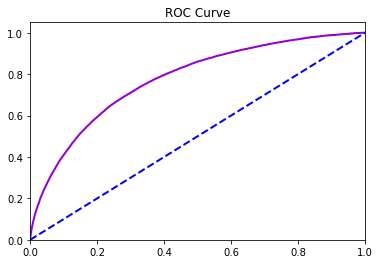

In [ ]:
# Plot ROC Curve Figure
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels, out_of_fold)
roc_auc = auc(fpr,tpr)

lw = 2
print(thresholds)

plt.figure()
plt.plot(fpr, tpr, color='darkviolet',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='b', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve')
plt.show() 

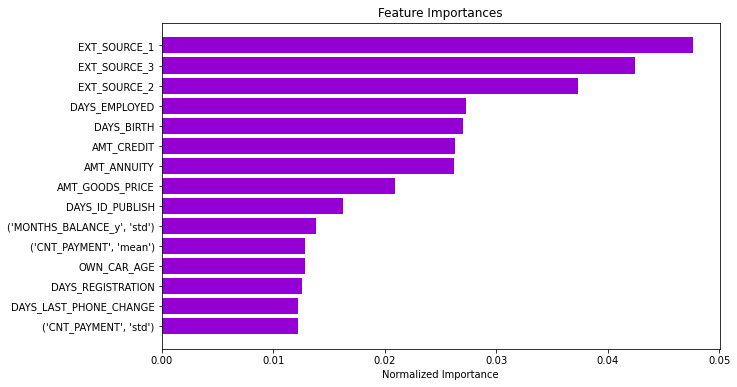

In [ ]:
# Plot Feature Importance Figure 
import matplotlib.pyplot as plt

# Sort the importacne in descending order
df_feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances
df_feature_importances['importance_normalized'] = df_feature_importances['importance'] / df_feature_importances['importance'].sum()

# Plot the feature importances in horizontal bar charts
plt.figure(figsize = (10, 6))
ax = plt.subplot()
ax.barh(list(reversed(list(df_train.index[:15]))), 
        df_feature_importances['importance_normalized'].head(15), 
        align = 'center', 
        color = 'darkviolet',
       )
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(df_train.index[:15]))))
ax.set_yticklabels(df_feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); 
plt.title('Feature Importances')
plt.show()

In [ ]:
# Output submission results
df_submission = pd.read_csv('./Data/sample_submission.csv')
df_submission['TARGET'] = test_predictions
df_submission["SK_ID_CURR"]=[int(x) for x in df_submission["SK_ID_CURR"]]
df_submission.to_csv('submission.csv', index=None)

#### LightGBM

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm
import gc

# Record data
features = new_train_X
labels = train_y
test_features = new_test_X

# Empty array for feature importances
feature_names = list(features.columns)
feature_importance_values = np.zeros(features.shape[1])

# Empty array for test predictions
test_predictions = np.zeros(test_features.shape[0])

# Empty array for out of fold validation predictions
out_of_fold = np.zeros(features.shape[0])

# Lists for recording validation and training scores
valid_scores = []
train_scores = []

# Create the kfold object
n_folds=5
k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

# Iterate through each fold
for train_indices, valid_indices in k_fold.split(features):

    # Training data for the fold
    train_features, train_labels = features.to_numpy()[train_indices], np.array(labels)[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = features.to_numpy()[valid_indices], np.array(labels)[valid_indices]

    # Create the model
    model = lgbm.LGBMClassifier(n_estimators=1000, 
                                objective = 'binary', 
                                class_weight = 'balanced', 
                                learning_rate = 0.05, 
                                reg_alpha = 0.1, 
                                reg_lambda = 0.1, 
                                subsample = 0.8, 
                                n_jobs = -1, 
                                random_state = 50,
                               )

    # Train the model
    model.fit(train_features, train_labels, 
              eval_metric = 'auc',
              eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
              eval_names = ['valid', 'train'],
              early_stopping_rounds = 100, 
              verbose = 200
             )

    # Record the best iteration
    best_iteration = model.best_iteration_

    # Record the feature importances
    feature_importance_values += model.feature_importances_ / k_fold.n_splits

    # Make predictions
    test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

    # Record the out of fold predictions
    out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

    # Record the best score
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']

    valid_scores.append(valid_score)
    train_scores.append(train_score)

    # Clean up memory
    gc.enable()
    del model, train_features, valid_features
    gc.collect()

df_submission = pd.read_csv('./Data/sample_submission.csv')
test_ids = df_submission['TARGET']

# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

# Make the feature importance dataframe
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

# Overall validation score
valid_auc = roc_auc_score(labels, out_of_fold)

# Add the overall scores to the metrics
valid_scores.append(valid_auc)
train_scores.append(np.mean(train_scores))

# Needed for creating dataframe of validation scores
fold_names = list(range(n_folds))
fold_names.append('overall')

# Dataframe of validation scores
metrics = pd.DataFrame({'fold': fold_names,
                        'train': train_scores,
                        'valid': valid_scores})
print(submission)
print(feature_importances)
print(metrics)

Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.521888	train's auc: 0.823624	valid's binary_logloss: 0.539908	valid's auc: 0.774148
Early stopping, best iteration is:
[274]	train's binary_logloss: 0.506978	train's auc: 0.837289	valid's binary_logloss: 0.530552	valid's auc: 0.775086
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.523646	train's auc: 0.82232	valid's binary_logloss: 0.540218	valid's auc: 0.780979
[400]	train's binary_logloss: 0.486398	train's auc: 0.856668	valid's binary_logloss: 0.517104	valid's auc: 0.781549
Early stopping, best iteration is:
[313]	train's binary_logloss: 0.501405	train's auc: 0.843103	valid's binary_logloss: 0.526278	valid's auc: 0.78163
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.522825	train's auc: 0.822959	valid's binary_logloss: 0.540237	valid's auc: 0.777876
[400]	train's binary_logloss: 0.485646	train's 

In [ ]:
out_of_fold

array([0.84595085, 0.15573859, 0.49673009, ..., 0.40495052, 0.27680007,
       0.55998925])

[1.9522443  0.9522443  0.94551457 ... 0.0295355  0.02952322 0.01062759]


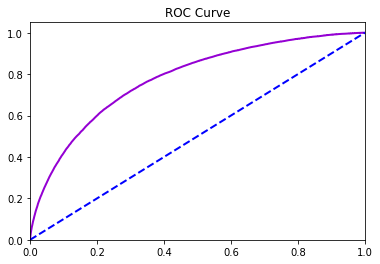

In [ ]:
# Plot ROC Curve Figure
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels, out_of_fold)
roc_auc = auc(fpr,tpr)

lw = 2
print(thresholds)

plt.figure()
plt.plot(fpr, tpr, color='darkviolet',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='b', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve')
plt.show() 

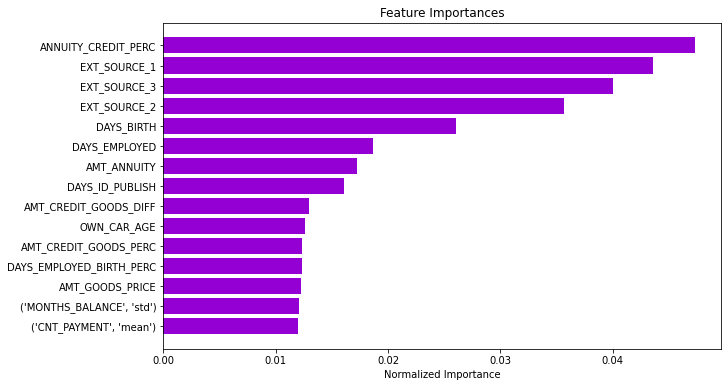

In [ ]:
# Plot Feature Importance Figure 
import matplotlib.pyplot as plt

# Sort the importacne in descending order
df_feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances
df_feature_importances['importance_normalized'] = df_feature_importances['importance'] / df_feature_importances['importance'].sum()

# Plot the feature importances in horizontal bar charts
plt.figure(figsize = (10, 6))
ax = plt.subplot()
ax.barh(list(reversed(list(df_train.index[:15]))), 
        df_feature_importances['importance_normalized'].head(15), 
        align = 'center', 
        color = 'darkviolet',
       )
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(df_train.index[:15]))))
ax.set_yticklabels(df_feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); 
plt.title('Feature Importances')
plt.show()

In [ ]:
# Output submission results
df_submission = pd.read_csv('./Data/sample_submission.csv')
df_submission['TARGET'] = test_predictions
df_submission["SK_ID_CURR"]=[int(x) for x in df_submission["SK_ID_CURR"]]
df_submission.to_csv('submission.csv', index=None)